In [57]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
#from tqdm import tqdm
from scipy.optimize import fsolve

plt.rcParams["figure.figsize"] = (10*4/5,7*4/5) 
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 'large'

In [58]:
L = 8

## Calculate degeneracy factors

In [59]:
# Warning -- this is very slow!
# Better just to import them
#import mpmath
#coefficients = mpmath.taylor(lambda q: mpmath.jtheta(3, 0, q)**3, 0, 200**2)
with open('coefficients.csv', 'r') as f:
    coefficients = [int(c) for c in f.read().split('\n')]
coefficients[:10]

[1, 6, 12, 8, 6, 24, 24, 0, 12, 30]

## Define Luscher function to convert energies to $p \cot \delta$

In [60]:
def _s3(eta, lamb):
    S0 = -8.91363291759831

    try:
        output = (
            - 1/eta
            + np.sum([coefficients[j] *(1/(j - eta) - 1/j) for j in range(1, lamb**2)])
            + S0
            + 4 *np.pi *np.sqrt(eta) *np.arctanh(np.sqrt(eta)/lamb)
        )
        return output
    except ZeroDivisionError:
        return np.inf

# adds a progress bar using tqdm
def s3(eta, lamb):
    if not hasattr(eta, '__len__'):
        return _s3(eta, lamb)
    else:
        return np.array([_s3(e, lamb) for index, e in tqdm(np.ndenumerate(eta), total=len(eta))])

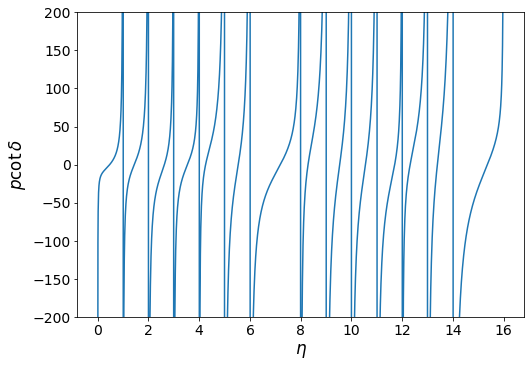

In [53]:
eta = np.linspace(-0.2, 16, 2000)
plt.plot(eta, s3(eta, L))
plt.ylim(-200,200) # must manually specify ylims
plt.xlabel('$\eta$')
plt.ylabel('$p \cot \delta$')
plt.show()

## Construct transfer matrix (eqn 57 in arXiv:1608.02563)

In [6]:
M = 5
cutoff = 0.99999

Define kinetic energy functional:
\begin{equation}
\xi\left(\overrightarrow p \right)  = \exp \left( 
    \frac{\overrightarrow{p} \cdot \overrightarrow{p} }{2 M} \right)
\end{equation}

In [7]:
def ke_functional(p):
    if np.dot(p, p) <= (cutoff *np.pi)**2:
        return np.exp(np.dot(p, p)/(2*M))
    else:
        return np.inf
# ke_functional([0.1, 0.1, 0.1])


Define:
\begin{align}
H_0 \left(\overrightarrow{p}, \overrightarrow{q} \right) 
&= \frac{\delta_{\overrightarrow{p},\overrightarrow{q}}}{\xi \left(\frac{2\pi}{L} \overrightarrow{p}\right) \xi \left(\frac{2\pi}{L} \overrightarrow{q}\right)} \\
V_0 \left(\overrightarrow{p}, \overrightarrow{q} \right) 
&= \frac{1}{\xi \left(\frac{2\pi}{L} \overrightarrow{p}\right) \xi \left(\frac{2\pi}{L} \overrightarrow{q}\right)} \\
V_n \left(\overrightarrow{p}, \overrightarrow{q} \right) 
&= \frac{M^n \left\{ 1 - \exp\left[ - \frac{1}{M} \left( \frac{2\pi}{L}  \left( p - q \right) \right)^2 \right]\right\}^n}{\xi \left(\frac{2\pi}{L} \overrightarrow{p}\right) \xi \left(\frac{2\pi}{L} \overrightarrow{q}\right)} 
\end{align}


In [8]:
all_momenta = np.array(list(itertools.product(np.arange(-L/2, L/2)+1, repeat=6)))

H0 = np.empty(L**6)
V0 = np.empty(L**6)
V1 = np.empty(L**6)
V2 = np.empty(L**6)
for j, v in enumerate(all_momenta):
    p, q = v[:3], v[3:]

    denominator = ke_functional((2 *np.pi/L)*p) *ke_functional((2 *np.pi/L)*q)

    # H0
    if (p == q).all():
        H0[j] = 1 / denominator
    else:
        H0[j] = 0

    # V0
    V0[j] = 1 / denominator

    # Vn
    Vn_numerator = lambda n, p, q, M : M**n *(1 - np.exp(-(1/M) *(2 *np.pi/L)**2 *np.dot(p-q, p-q)))**n
    V1[j] = Vn_numerator(1, p, q, M) / denominator
    V2[j] = Vn_numerator(2, p, q, M) / denominator

H0 = H0.reshape(L**3, L**3, order='C')
V0 = V0.reshape(L**3, L**3, order='C')
V1 = V1.reshape(L**3, L**3, order='C')
V2 = V2.reshape(L**3, L**3, order='C')

## Compute eigenvalues of transfer matrix

In [32]:
c = 0.1

eigenvalues = np.linalg.eigvals(H0 + c *(4 *np.pi/(M *L**3)) *V0)
eigenvalues = np.sort(eigenvalues[np.nonzero(eigenvalues)])[::-1] # drop elements == 0, sort from highest to lowest

## Compute energies from eigenvalues of transfer matrix

In [33]:
eta = M * -np.log(eigenvalues) *( L/(2 *np.pi) )**2

## Evaluate $\eta$,$p \cot \delta$ using Luscher relation

In [34]:
pcotd = s3(eta, 200).real / (np.pi * L)

# Exclude infinite values
indicies = [np.abs(pcotd) < 100]
eta = eta[indicies]
pcotd = pcotd[indicies]

100%|██████████| 251/251 [00:04<00:00, 55.75it/s]


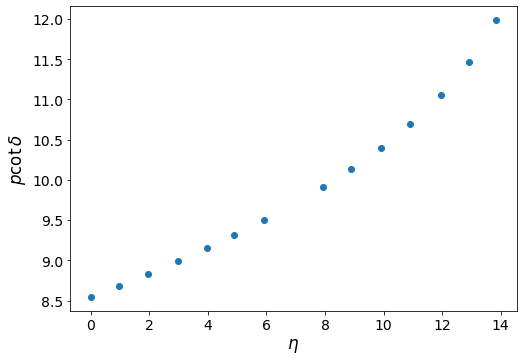

In [35]:
plt.figure().clear()
plt.plot(eta, pcotd, 'o')
plt.xlabel('$\eta$')
plt.ylabel('$p \cot \delta$')
plt.show()

## Fit pcot$\delta$ using effective range expansion to a given order

Change these values as needed:

In [36]:
# least squares polynomial fit
params = 1  # Degree of polynomial. e.g., params = 1 fits to NLO: pcotd = -1/a + 1/2 r_0 p^2
points = 8  # Number of data points included in the fit, starting with the ground state  
search_bounds = [-2,0]  # range of eta used to look for a bound state pole

# returns coefficients of Taylor expansion, covariance matrix
fit, cov = np.polyfit(eta[:points],pcotd[:points],params,cov=True)

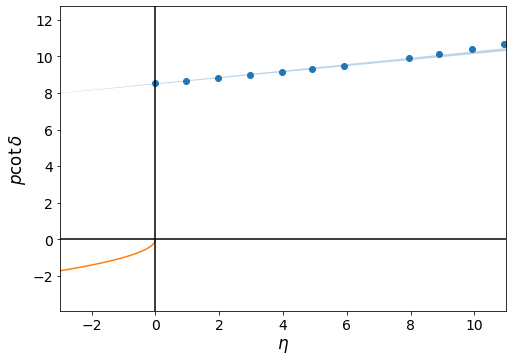

In [40]:
# Plot the data
plt.xlabel('$\eta$')
plt.ylabel('$p \cot \delta$')
plt.plot(eta, pcotd, 'o')
etax = np.linspace(-10, 16, 2000)
fit_min = np.polyval(fit-np.sqrt(np.diag(cov)),etax)
fit_max = np.polyval(fit+np.sqrt(np.diag(cov)),etax)
plt.fill_between(etax,fit_min,fit_max,alpha=.3)
plt.plot(etax,-np.sqrt(-etax))
plt.xlim([-3,11])
#plt.ylim([-1, 1])
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

# Find intersection of orange line and blue band
eta_search = np.linspace(search_bounds[0],search_bounds[1], 2000)
fit_min = np.polyval(fit-np.sqrt(np.diag(cov)),eta_search)
fit_max = np.polyval(fit+np.sqrt(np.diag(cov)),eta_search)
#valid_e = [eta_search[e] for e in range(len(eta_search)) if (fit_min[e] < -np.sqrt(-eta_search[e])) and (fit_max[e] > -np.sqrt(-eta_search[e])) ]
#print("binding energy range = " + str([np.min(valid_e), np.max(valid_e)]))

## Generate toy bootstrap data for Luscher

Change these values as needed:

In [15]:
var = 1/20 # Variance for the generated noise
n_bs = 50  # Number of bootstrap samples

In [16]:
eta_bs = np.concatenate([np.random.normal(eta[j], var, n_bs) for j in range(len(eta))])
pcotd_bs = s3(eta_bs+0.0j, 200).real/(np.pi *L)

100%|██████████| 650/650 [00:11<00:00, 55.98it/s]


Plotting the bootstrapped data, showing Luscher function as dashed lines for comparison 

100%|██████████| 2000/2000 [00:07<00:00, 264.87it/s]


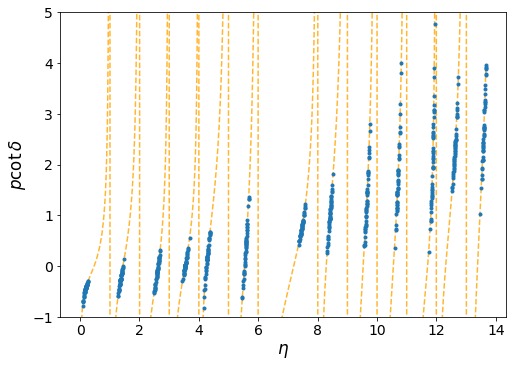

In [17]:
# The next two lines are a bit slow --
# speed-up by either reducing `n` in `np.linspace(-0.2, np.max(eta_bs), n)`
# or `lamb` in `s3(eta, lamb)`.
# Both will affect accuracy, 
# though the latter seems to have a smaller impact
eta_all = np.linspace(-0.2, np.max(eta_bs), 2000)
plt.plot(eta_all, s3(eta_all, 100)/(np.pi *L), color='orange', alpha=0.8, ls='--')

plt.plot(eta_bs, pcotd_bs, '.')
plt.ylim(-1, 5)
plt.xlabel('$\eta$')
plt.ylabel('$p \cot \delta$')
plt.show()

## Fit pcot$\delta$ using effective range expansion to a given order

Change these values as needed:

In [18]:
# polynomial fit
params = 1  # Degree of polynomial. e.g., params = 1 fits to NLO: pcotd = -1/a + 1/2 r_0 p^2
points = 8  # Number of data points included in the fit, starting with the ground state  
search_bounds = [-2,0]  # range of eta used to look for a bound state pole

fit = dict()
for j in range(n_bs):
    fit[j] = np.polyfit([eta_bs[k*n_bs+j] for k in range(points)],[pcotd_bs[k*n_bs+j] for k in range(points)],params) 

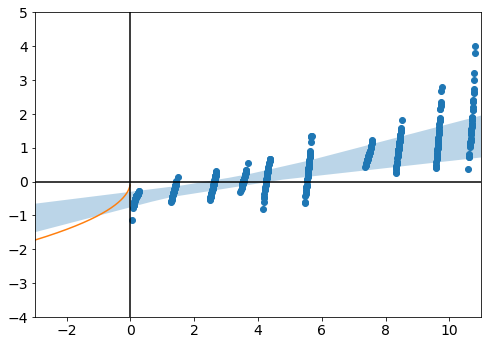

binding energy range = [-1.0305152576288146, -0.10105052526263147]


In [19]:
# plot the data
plt.plot(eta_bs, pcotd_bs, 'o')
etax = np.linspace(-10, 16, 2000)
fit_max = np.amax([np.polyval(fit[key],etax) for key in fit],axis=0)
fit_min = np.amin([np.polyval(fit[key],etax) for key in fit],axis=0)
plt.fill_between(etax,fit_max,fit_min,alpha=.3)
plt.plot(etax,-np.sqrt(-etax))
plt.xlim([-3,11])
plt.ylim([-4, 5])
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

# find intersection of orange line and blue band
eta_search = np.linspace(search_bounds[0],search_bounds[1], 2000)
fit_max = np.amax([np.polyval(fit[key],eta_search) for key in fit],axis=0)
fit_min = np.amin([np.polyval(fit[key],eta_search) for key in fit],axis=0)
valid_e = [eta_search[e] for e in range(len(eta_search)) if (fit_min[e] < -np.sqrt(-eta_search[e])) and (fit_max[e] > -np.sqrt(-eta_search[e])) ]
print("binding energy range = " + str([np.min(valid_e), np.max(valid_e)]))

## Add systematic error to data

Change these values as needed:

In [61]:
sys_err = 0.01  # Size of systematic shift subtracted from data points
variable_err = False  # False to produce constant shift to all data points; True to produce shift that increases with increading eta

In [62]:
for x in eta_bs:
    print(x, x - (sys_err*x+0.0j))


(4.271850308802362+0j) (4.2291318057143386+0j)
(4.341083593168169+0j) (4.297672757236487+0j)
(4.3515266471116405+0j) (4.308011380640524+0j)
(4.254569138085267+0j) (4.212023446704414+0j)
(4.154273911080832+0j) (4.112731171970023+0j)
(4.290395018927429+0j) (4.247491068738155+0j)
(4.239653306845811+0j) (4.197256773777353+0j)
(4.249983652661141+0j) (4.20748381613453+0j)
(4.274375765000262+0j) (4.231632007350259+0j)
(4.321216575259742+0j) (4.278004409507145+0j)
(4.3479675453090145+0j) (4.304487869855924+0j)
(4.255505340621683+0j) (4.212950287215467+0j)
(4.216510996674794+0j) (4.174345886708046+0j)
(4.275663509604863+0j) (4.2329068745088145+0j)
(4.135817440018775+0j) (4.094459265618587+0j)
(4.2276813372582165+0j) (4.1854045238856346+0j)
(4.281225676948732+0j) (4.238413420179245+0j)
(4.260208556513041+0j) (4.217606470947911+0j)
(4.2995764653229+0j) (4.256580700669671+0j)
(4.1683288263840055+0j) (4.126645538120165+0j)
(4.329105264202451+0j) (4.285814211560426+0j)
(4.219103453267422+0j) (4.176

In [55]:
if variable_err:
    eta_bs = [x - (sys_err*x+0.0j) for x in eta_bs]
else:
    eta_bs = [x - (sys_err+0.0j) for x in eta_bs]   


pcotd_bs = s3(eta_bs, 200).real/(np.pi *L)

KeyboardInterrupt: 

Change these values as needed:

In [22]:
# polynomial fit
params = 1  # Number of paramaters in the fit. e.g., params = 1 fits to NLO: pcotd = -1/a + 1/2 r_0 p^2
points = 8  # Number of data points included in the fit, starting with the ground state  
search_bounds = [-2,0]  # range of eta used to look for a bound state pole

fit = dict()
for j in range(n_bs):
    fit[j] = np.polyfit([eta_bs[k*n_bs+j] for k in range(points)],[pcotd_bs[k*n_bs+j] for k in range(points)],params) 

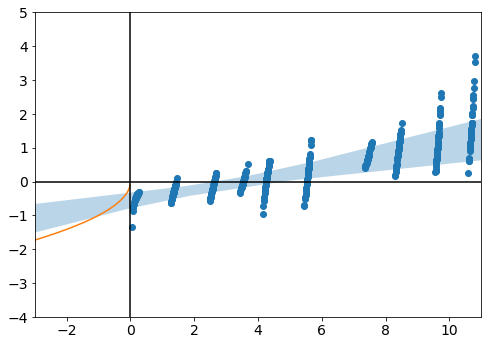

binding energy range = [-1.1145572786393196, -0.11705852926463245]


In [23]:
# plot the data
plt.plot(eta_bs, pcotd_bs, 'o')
etax = np.linspace(-10, 16, 2000)
fit_max = np.amax([np.polyval(fit[key],etax) for key in fit],axis=0)
fit_min = np.amin([np.polyval(fit[key],etax) for key in fit],axis=0)
plt.fill_between(etax,fit_max,fit_min,alpha=.3)
plt.plot(etax,-np.sqrt(-etax))
plt.xlim([-3,11])
plt.ylim([-4, 5])
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

# find intersection of orange line and blue band
eta_search = np.linspace(search_bounds[0],search_bounds[1], 2000)
fit_max = np.amax([np.polyval(fit[key],eta_search) for key in fit],axis=0)
fit_min = np.amin([np.polyval(fit[key],eta_search) for key in fit],axis=0)
valid_e = [eta_search[e] for e in range(len(eta_search)) if (fit_min[e] < -np.sqrt(-eta_search[e])) and (fit_max[e] > -np.sqrt(-eta_search[e])) ]
print("binding energy range = " + str([np.min(valid_e), np.max(valid_e)]))